# Taobao 2020 Double 11 Team Competition

Q: What's the distribution of total gain for teams? How much does this game cost Taobao? 

## Model

Build a simplified version of the game. 
The following are my conjectures:
- Taobao creates an illusion of winning: teams win and lose like a pendulum, but in the end gain very few
- because p_s = e_s + e_s+1, the prices could be set high without much real cost to Taobao 
    - it only has to pay the price of the lowest stage for <50% of teams and the highest price for very few teams 

Parameters:
- N: total number of teams in this game
    - In 2019, the active users of Taobao is 0.65 billion.
- mu_i: quality of each team i follows a Pareto distribution with parameter alpha
    - i.e., mu_i ~ Pareto(alpha)
    - the realized popularity of team i changes daily: popular_i ~ Normal(mu_i, 0.5)
- S: total number of stages of the game
    - total number of days played = S+1
- e_s: entry fee at stage s, \[0, S\], which is parameterized as follows
    - e_s = 2**(s)-1, so that e_0=0, e_1=1, e_2=3
- p_s: price for winners at stage s
    - p_s = e_s + e_s+1 (specified by Taobao)

Rules:
- each team pays entry fee to enter the game
- teams of the same stage are matched randomly 
- winners of stage s proceed to min{s+1, S}
- losers of stage s retreat to max{s-1, 0}
- teams not matched are set to win by default


## Simulation

In [44]:
import numpy as np
import pandas as pd
import random
from scipy.stats import pareto, norm


In [180]:
## Set parameters 

N = 100 #10000
alpha = 1.5
S = 4 # 4 or 7 in reality
random.seed(2020)

## Generate teams with endowed quality
df = pd.Series(range(1, N+1), name='teamID').to_frame()
df['mu'] = pareto.rvs(alpha, size=N)

## Generate fees and winner prices
e = [2**x-1 for x in range(0, S+1)]
p = [e[x]+e[x+1] for x in range(0, S)]
p.append(2*e[-1]) # highest price equals twice the entry fee

dict_e = {i:e[i] for i in range(0, S+1)} # stage : entry fee
dict_p = {i:p[i] for i in range(0, S+1)} # stage : winner price

##======= Teams are ready =========

df.head()


,teamID,mu
0,1,1.261272
1,2,1.519387
2,3,2.579706
3,4,1.564742
4,5,1.127700


In [181]:
## ========= start of the game ===============

# all the teams start from stage 0 on day 0
# stage will be updated by the end of each day
df['stage_0'] = 0

for d in range(S+1): # d = 0, 1, 2, .., S 
    # generate the realization of team polularity, updating each day
    df['popular'] = norm.rvs(df.mu, 0.5)
    # generate a random sequance (without duplicates) for same-stage teams
    # x: sub-group
    df['r'] = df.groupby('stage_{0}'.format(d)).apply(lambda x: random.sample(range(1, len(x)+1), len(x)))
    df['r'] = df.groupby('stage_{0}'.format(d)).transform(lambda x: random.sample(range(1, len(x)+1), len(x)))
    df['r'] = df.r + 0.1    # +0.1 to solve the 'round half to even' rule of python 3
    
    # assign group number for each pair of teams
    df['g'] = (df.r/2).round(0).astype('int')
    # generate winner dummy if popular = popular.max
    df['win_{0}'.format(d)] = (df.groupby('g')['popular'].transform(max) == df.popular)*1
    # entry fee and potential price (depends on current gaming stage)
    df['e'] = df['stage_{0}'.format(d)].map(dict_e)
    df['p'] = df['stage_{0}'.format(d)].map(dict_p)
    # net price (profit) for each team on day d
    df['price_{0}'.format(d)] = df.p*df['win_{0}'.format(d)] - df.e
    
    # update 'stage' for the next day: gen stage_2 = stage_1+1 if win
    df['w'] = df['win_{0}'.format(d)]
    df['s'] = df['stage_{0}'.format(d)]
    df.loc[df.w==1, 'stage_{0}'.format(d+1)] = df['stage_{0}'.format(d)] + 1
    df.loc[df.w==0, 'stage_{0}'.format(d+1)] = df['stage_{0}'.format(d)] - 1
    df['ss'] = df['stage_{0}'.format(d+1)]
    df.loc[df.ss>S, 'stage_{0}'.format(d+1)] = df['stage_{0}'.format(d)] # max = S
    df.loc[df.ss<0, 'stage_{0}'.format(d+1)] = df['stage_{0}'.format(d)] # min = 0

## ======= end of the game ===========

# drop intermediate vars
df.drop(['popular', 'r', 'g', 'e', 'p', 'w', 's', 'ss'], axis=1, inplace=True)
# create accumulated prices for each team
df['accum_price'] = df.filter(regex='^price', axis=1).sum(axis=1)

df.head()


,teamID,mu,stage_0,win_0,price_0,stage_1,win_1,price_1,stage_2,win_2,price_2,stage_3,win_3,price_3,stage_4,win_4,price_4,stage_5,accum_price
0,1,1.261272,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0
1,2,1.519387,0,0,0,0.0,0,0,0.0,1,1,1.0,0,-1,0.0,1,1,1.0,1
2,3,2.579706,0,0,0,0.0,1,1,1.0,0,-1,0.0,0,0,0.0,1,1,1.0,1
3,4,1.564742,0,1,1,1.0,0,-1,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0
4,5,1.127700,0,1,1,1.0,0,-1,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0


## Result

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


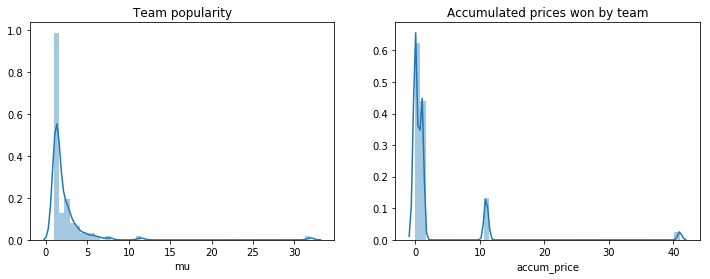

In [182]:
## distribution of team quality and accumulated prices won
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4) )
sns.distplot(df.mu, hist=True, ax=ax[0])
ax[0].set_title('Team popularity')
sns.distplot(df.accum_price, ax=ax[1])
ax[1].set_title('Accumulated prices won by team')
plt.show()


In [183]:
## the share of 'empty joy' teams
display(df.accum_price.value_counts(normalize=True))

# display the entry fee and prices for each stage
print(dict_e)
print(dict_p)

0     0.51
1     0.36
11    0.11
41    0.02
Name: accum_price, dtype: float64

{0: 0, 1: 1, 2: 3, 3: 7, 4: 15}
{0: 1, 1: 4, 2: 10, 3: 22, 4: 30}


In [184]:
## Simulated total cost of Taobao
df.accum_price.sum()


239

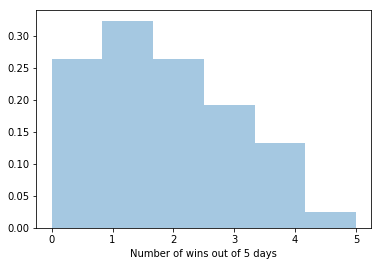

In [193]:
## how about the number of times teams win?
df['accum_win'] = df.filter(regex='^win', axis=1).sum(axis=1)
sns.distplot(df.accum_win, bins=S+2, norm_hist=True, kde=False)
plt.xlabel('Number of wins out of %.0f days' %(S+1))
plt.show()

Analysis:
- The distribution of prices is more dispersed than the distribution of winning times.
    - e.g., 25% of teams did not win a game while 51% of teams did not receive any prices.

## Difference from reality

The above toy model can be improved to incorporate more features in reality.
- it allows teams of different sizes (2-5 members) to enter different pools
- stages depends on accumulated prices instead of previous win/lose status
- the real prices for each stage:
- the real enty fee for each stage: 
- each team starts with an initial endownment
